In [1]:
import pandas as pd
import numpy as np
import csv
from pyfaidx import Fasta
from collections import defaultdict
import gffpandas.gffpandas as gffpd
import roman
import urllib
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [2]:
folder1 = 'D:/Users/ernes/Documents/1KCL/Zelezniak/Testing/Folder1/'
#Folder2 must contain the location of the gff, fasta, and filenames list in order for this code to work
folder2 = 'D:/Users/ernes/Documents/1KCL/Zelezniak/Testing/Folder2/'
#Loading filenames from previous species names code; check github for more details on the previous coded
filenames = np.load('D:/Users/ernes/Documents/1KCL/Zelezniak/Testing/Folder2/filenames_organisms_1_10_19.npy')
#Printing out the filenames that will be processed
filenames = filenames
print(filenames)

['Arabidopsis_thaliana.TAIR10.41.gff3.gz']


In [3]:
def read_gff3_df_list(folder,fnames):
    #Reads gff3 files to list of data frames
    gff3_list = []
    #Iterate over each filename in the provided list of filenames
    for fname in fnames:
        #Read the GFF3 file using gffpd and the specified folder and filename
        annotation = gffpd.read_gff3(folder+fname[:-3])
        #Extract and append the data frame from the annotation object to list
        gff_df = annotation.df
        gff3_list.append(gff_df)
    return gff3_list

In [4]:
#Get the regions
gff3_list = read_gff3_df_list(folder2,filenames)
print(gff3_list)

D:\Users\ernes\Documents\Anaconda\lib\site-packages\gffpandas\gffpandas.py:21: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  self._read_gff3_to_df()


[       seq_id                                source            type   start  \
0           1  The Arabidopsis Information Resource      chromosome       1   
1           1                             araport11            gene    3631   
2           1                             araport11            mRNA    3631   
3           1                             araport11  five_prime_UTR    3631   
4           1                             araport11            exon    3631   
...       ...                                   ...             ...     ...   
795714     Pt                             araport11            exon  153878   
795715     Pt                             araport11             CDS  153878   
795716     Pt                        Ensembl_Plants      ncRNA_gene  153801   
795717     Pt                        Ensembl_Plants         lnc_RNA  153801   
795718     Pt                        Ensembl_Plants            exon  153801   

             end score strand phase  \
0       304

In [5]:
def extract_longest_names(gff3):
    #Extract mrna_id to gene_id data + groupby select longest transcript'''
    id_convert = pd.DataFrame(columns=['gene_id','mrna_id','mrna_len','mrna_idx'])
    select = gff3[gff3.type=='mRNA']
    select.head()
    id_convert['mrna_id'] = select.attributes.str.split(';').apply(lambda x: x[0].split(':')[1])
    id_convert['gene_id'] = select.attributes.str.split(';').apply(lambda x: x[1].split(':')[1])
    id_convert['mrna_len'] = np.absolute(select.start-select.end)
    id_convert['mrna_idx'] = id_convert.index
    id_convert = id_convert.reset_index(drop=True)
    
    id_convert_idxmax = id_convert.groupby(['gene_id'])['mrna_len'].idxmax()
    id_convert_max = id_convert.iloc[id_convert_idxmax.values]
    return id_convert_max

def group_regions_list(gff3_max,c_name):
    #Obtain regions as list from dframe
    dfcopy = gff3_max.assign(limits_list = gff3_max[gff3_max.type == c_name][['start','end']].apply(lambda x: x.values,axis=1)) #(lambda x: x.tolist(),axis=1)
    out = dfcopy[dfcopy.type == c_name].groupby('id')['limits_list'].agg({'list': list}) #pass python function
    return out

In [6]:
def parse_attributes(attr_string, key):
    attributes = {}
    attr_pairs = attr_string.split(";")
    
    for pair in attr_pairs:
        k, v = pair.split("=")
        attributes[k] = v
    
    return attributes.get(key, None)

def calculate_promoter_limits(start, end, strand, len_prom):
    if strand == '+':
        return [[start - len_prom + 1, start]]
    elif strand == '-':
        return [[end, end + len_prom - 1]]  

def calculate_terminator_limits(start, end, strand, len_term):
    if strand == '+':
        return [[end, end + (len_term // 2) - 1]]
    elif strand == '-':
        return [[start - (len_term // 2) + 1, start]]
    
def calculate_full_promoter_limits(start, end, strand, len_prom_f):
    if strand == '+':
        return [[start - len_prom_f[0] + 1, start + len_prom_f[1]]]
    elif strand == '-':
        return [[end - len_prom_f[1], end + len_prom_f[0] - 1]]

def calculate_full_terminator_limits(start, end, strand, len_term_f):
    if strand == '+':
        return [[end - len_term_f[0], end + len_term_f[1] - 1]]
    elif strand == '-':
        return [[start - len_term_f[1] + 1, start + len_term_f[0]]]

    
def parse_gff3_to_regions(gff3_list, len_prom=1000, len_term=1000):
    #Define the len_prom_f and len_term_f values
    len_prom_f = [int(1000), int(500)]
    len_term_f = [int(500), int(500)]   
    
    #Concatenate all the DataFrames in gff3_list
    gff3_df = pd.concat(gff3_list)
    gff3_df.reset_index(drop=True, inplace=True)

    gene_df = gff3_df[gff3_df["type"] == "gene"].copy()
    mrna_df = gff3_df[gff3_df["type"] == "mRNA"].copy()

    #Extract gene_id, mrna_id and mrna_parent
    gene_df["gene_id"] = gene_df["attributes"].apply(lambda x: parse_attributes(x, "ID"))
    mrna_df["mrna_id"] = mrna_df["attributes"].apply(lambda x: parse_attributes(x, "ID"))
    mrna_df["gene_id"] = mrna_df["attributes"].apply(lambda x: parse_attributes(x, "Parent"))

    #Find the longest transcripts
    longest_transcripts = extract_longest_names(gff3_df)
    
    #Modify the mrna_id format to match the one in mrna_df
    longest_transcripts['mrna_id'] = 'transcript:' + longest_transcripts['mrna_id']

    #Filter mrna_df to keep only the longest transcripts
    mrna_df = mrna_df[mrna_df["mrna_id"].isin(longest_transcripts["mrna_id"])]

    #Merge gene and mRNA DataFrames
    dframe = pd.merge(gene_df, mrna_df, left_on="gene_id", right_on="gene_id", suffixes=("_gene", "_mrna"))
   
    #Extract start and end positions of CDS, 5' UTR, and 3' UTR regions
    cds_df = gff3_df[gff3_df["type"] == "CDS"].copy()
    five_prime_utr_df = gff3_df[gff3_df["type"] == "five_prime_UTR"].copy()
    three_prime_utr_df = gff3_df[gff3_df["type"] == "three_prime_UTR"].copy()

    cds_df["mrna_id"] = cds_df["attributes"].apply(lambda x: parse_attributes(x, "Parent"))
    five_prime_utr_df["mrna_id"] = five_prime_utr_df["attributes"].apply(lambda x: parse_attributes(x, "Parent"))
    three_prime_utr_df["mrna_id"] = three_prime_utr_df["attributes"].apply(lambda x: parse_attributes(x, "Parent"))

    #Create a function to aggregate the start and end positions
    def aggfunc(x):
        return list(zip(x["start"], x["end"]))

    #Group the data by mRNA ID and aggregate the start and end positions
    cds_grouped = cds_df.groupby("mrna_id").apply(aggfunc).reset_index(name="cds_list")
    five_prime_utr_grouped = five_prime_utr_df.groupby("mrna_id").apply(aggfunc).reset_index(name="5utr_list")
    three_prime_utr_grouped = three_prime_utr_df.groupby("mrna_id").apply(aggfunc).reset_index(name="3utr_list")

    #Merge the grouped data with the main DataFrame
    dframe = pd.merge(dframe, cds_grouped, on="mrna_id", how="left")
    dframe = pd.merge(dframe, five_prime_utr_grouped, on="mrna_id", how="left")
    dframe = pd.merge(dframe, three_prime_utr_grouped, on="mrna_id", how="left")

    dframe.dropna(subset=['cds_list', 'start_gene', 'end_gene', '5utr_list', '3utr_list'], inplace=True)
    
    #Fill the empty columns with associated data
    dframe["cds_len"] = dframe["cds_list"].apply(lambda x: sum([end - start for start, end in x]) if isinstance(x, (list, tuple)) else 0)
    dframe["5utr_len"] = dframe["5utr_list"].apply(lambda x: sum([end - start for start, end in x]) if isinstance(x, (list, tuple)) else 0)  # Changed this line
    dframe["3utr_len"] = dframe["3utr_list"].apply(lambda x: sum([end - start for start, end in x]) if isinstance(x, (list, tuple)) else 0)

    dframe['prom_list'] = dframe.apply(lambda x: calculate_promoter_limits(x['start_gene'], x['end_gene'], x['strand_gene'], len_prom), axis=1)
    dframe['term_list'] = dframe.apply(lambda x: calculate_terminator_limits(x['start_gene'], x['end_gene'], x['strand_gene'], len_term), axis=1)

    dframe['prom_full_list'] = dframe.apply(lambda x: calculate_full_promoter_limits(x['start_gene'], x['end_gene'], x['strand_gene'], len_prom_f), axis=1)
    dframe['term_full_list'] = dframe.apply(lambda x: calculate_full_terminator_limits(x['start_gene'], x['end_gene'], x['strand_gene'], len_term_f), axis=1)


    #Reorder the columns
    dframe = dframe[[
    "gene_id", "mrna_id", "cds_list", "5utr_list", "3utr_list",
    "start_gene", "end_gene", "strand_gene", "seq_id_gene",
    "prom_list", "term_list", "prom_full_list", "term_full_list",
    "cds_len", "5utr_len", "3utr_len"]]

    # Rename the columns
    dframe.columns = ['gene_id', 'mrna_id', 'cds_list', '5utr_list', '3utr_list', 'ostart', 'oend', 'strand', 'seq_id',
                  'prom_list', 'term_list', 'prom_full_list', 'term_full_list', 'cds_len', '5utr_len', '3utr_len']
    
    return dframe

In [7]:
regions_list = parse_gff3_to_regions(gff3_list)

In [8]:
print(regions_list.shape)
regions_list.head()

(22580, 16)


,gene_id,mrna_id,cds_list,5utr_list,3utr_list,ostart,oend,strand,seq_id,prom_list,term_list,prom_full_list,term_full_list,cds_len,5utr_len,3utr_len
0,gene:AT1G01010,transcript:AT1G01010.1,"[(3760, 3913), (3996, 4276), (4486, 4605), (47...","[(3631, 3759)]","[(5631, 5899)]",3631,5899,+,1,"[[2632, 3631]]","[[5899, 6398]]","[[2632, 4131]]","[[5399, 6398]]",1284,128,268
1,gene:AT1G01020,transcript:AT1G01020.3,"[(6915, 7069), (7157, 7232), (7384, 7450), (75...","[(8443, 8464), (8571, 9130)]","[(6788, 6914)]",6788,9130,-,1,"[[9130, 10129]]","[[6289, 6788]]","[[8630, 10129]]","[[6289, 7288]]",704,580,126
2,gene:AT1G01030,transcript:AT1G01030.1,"[(11864, 12940)]","[(12941, 13173), (13335, 13714)]","[(11649, 11863)]",11649,13714,-,1,"[[13714, 14713]]","[[11150, 11649]]","[[13214, 14713]]","[[11150, 12149]]",1076,611,214
3,gene:AT1G01040,transcript:AT1G01040.1,"[(23519, 24451), (24542, 24655), (24752, 24962...","[(23121, 23518)]","[(31080, 31227)]",23121,31227,+,1,"[[22122, 23121]]","[[31227, 31726]]","[[22122, 23621]]","[[30727, 31726]]",5710,397,147
4,gene:AT1G01050,transcript:AT1G01050.1,"[(31382, 31424), (31521, 31602), (31693, 31813...","[(33029, 33171)]","[(31170, 31381)]",31170,33171,-,1,"[[33171, 34170]]","[[30671, 31170]]","[[32671, 34170]]","[[30671, 31670]]",631,142,211


In [9]:
def analyse_regions(regions):
    '''plots some info'''

    #Max and min lengths of UTR regions
    print("Max 5'UTR length:", regions['5utr_len'].max())
    print("Max 3'UTR length:", regions['3utr_len'].max())
    print("Min 5'UTR length:", regions['5utr_len'].min())
    print("Min 3'UTR length:", regions['3utr_len'].min())
    print()

    #5'UTR length histogram
    regions['5utr_len'].hist(bins = 100)
    plt.title("5'UTR Length Distribution")
    plt.xlabel('Length (bp)')
    plt.ylabel('Frequency')
    plt.show()

    #Proportion of 5'UTR lengths greater than 300
    print("Proportion of 5'UTR lengths > 300:",
          sum(regions['5utr_len']>300)/regions.shape[0])

    #3'UTR length histogram
    regions['3utr_len'].hist(bins = 100)
    plt.title("3'UTR Length Distribution")
    plt.xlabel('Length (bp)')
    plt.ylabel('Frequency')
    plt.show()

    #Proportion of 3'UTR lengths greater than 350
    print("Proportion of 3'UTR lengths > 350:",
          sum(regions['3utr_len']>350)/regions.shape[0])

    #Number of 0 length 5'UTR and 3'UTR regions
    print("Number of 0 length 5'UTR regions:",
          len(regions[regions['5utr_len']==regions['5utr_len'].min()]))
    print("Number of 0 length 3'UTR regions:",
          len(regions[regions['3utr_len']==regions['3utr_len'].min()]))
    print()

    #CDS length histogram
    regions.cds_len.hist(bins = 100)
    plt.title('CDS Length Distribution')
    plt.xlabel('Length (bp)')
    plt.ylabel('Frequency')
    plt.show()

Max 5'UTR length: 3679
Max 3'UTR length: 3817
Min 5'UTR length: 0
Min 3'UTR length: 0



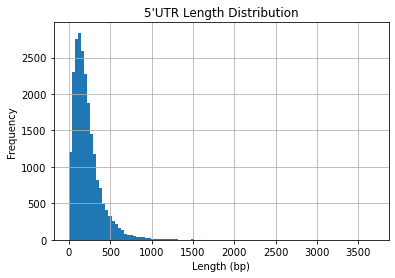

Proportion of 5'UTR lengths > 300: 0.2242249778565102


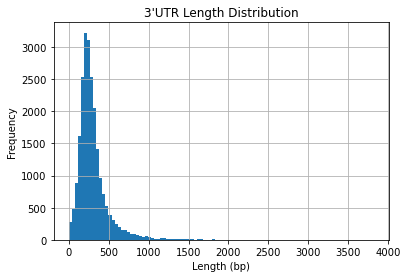

Proportion of 3'UTR lengths > 350: 0.2470770593445527
Number of 0 length 5'UTR regions: 17
Number of 0 length 3'UTR regions: 6



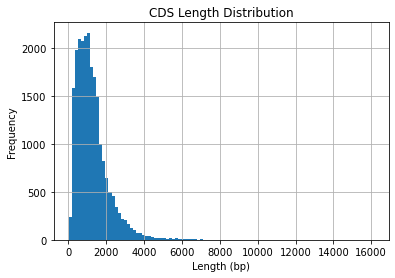

In [10]:
#Analysis of UTR regions    
analyse_regions(regions_list)

In [11]:
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases

def GC_content(seq):
    if len(seq) > 0:
        output = sum([i in ['G','C'] for i in seq])/len(seq)
    else:
        output = 0
    return output

def return_ATG_codons(seqs):
    '''return ATG codons filtered coding sequences'''
    print(pd.Series.value_counts(seqs['coding'].str.slice(0,3)).head())
    return seqs['coding'].str.slice(0,3) == 'ATG'

def extract_region_from_list(chrx,region,strand):
    '''concatenates exons'''
    #Fixes discrepancy between pyfaidx/python and gff indexing
    #Adapted to case that list values not int type
    seq_list = []
    # check if any nan
    if not np.any(pd.isna(region)) and not not region[0][0]:
        for i in range(len(region)):
            if (int(region[i][1])-int(region[i][0])) > 0:
                seq_list.append(str(chrx[int(region[i][0])-1:int(region[i][1])]))
            else:
                seq_list.append('')
        out = ''.join(seq_list)
        if strand in '-':
            out = reverse_complement(out)
    else:
        out = ''
    return str(out)

def extract_genes_from_fasta(species_name,species_dframe,folder,len_prom=int(1000),len_term=int(500)):
    #Extract from fasta - load, extract, return dframe
    #Script also returns UTR GC contents
    
    #Initilaize
    len_utr5 = int(300)
    len_utr3 = int(350)
    len_prom = int(1000)
    len_term = int(500)
    len_prom_f = [int(1000),int(500)]
    len_term_f = [int(500),int(500)]
    
    #Build fasta files as a dictionary for easier indexing
    fasta_path = folder2 + filenames[0][:-11] + '.dna.toplevel.fa'  # Create the full path to the FASTA file
    print(fasta_path)
    chrx = Fasta(fasta_path)
    
    orf_data = species_dframe.copy(deep=True)
    orf_data.reset_index(drop=True,inplace=True) # just in case
    
    #Based on input dframe with boundaries extract genes
    orf_seqs = pd.DataFrame(columns=['gene_id','prom','prom_full','5UTR','coding','3UTR','term','term_full'])
    orf_vars = pd.DataFrame(columns=['gene_id','prom','prom_full','5UTR',
                                  '3UTR','term','term_full','len_cd',
                                  'len_5u','len_3u','freq_cd','GC1',
                                  'GC2','GC3','gc_5u','gc_3u'])
    
    for k, row in orf_data.iterrows():
        #Print(k)

        #Do not include genes from mitochondrial chromosome 'mt'
        chr_num = str(row.seq_id)
        if not(chr_num == 'mt'): # can be omitted
            
            #Edge cases on chromosomes - ignore these few genes
            if orf_data.at[k,'strand'] == '+':
                ostart = int(orf_data.at[k,'ostart'])
                oend = int(orf_data.at[k,'oend'])
                if ((ostart-len_prom)<0 or (oend+len_term)>len(chrx[chr_num])):
                    print('out of bounds at sequence start')
                    continue
            else:
                ostart = int(orf_data.at[k,'oend'])
                oend = int(orf_data.at[k,'ostart'])
                if ((ostart+len_prom)>len(chrx[chr_num]) or (oend-len_term)<0):
                    print('out of bounds at sequence end')
                    continue
            
            #Save lengths to final data frame
            orf_seqs.at[k,'gene_id'] = row['gene_id']
            orf_vars.at[k,'gene_id'] = row['gene_id']
            orf_vars.at[k,'len_5u'] = row['5utr_len']
            orf_vars.at[k,'len_3u'] = row['3utr_len']
                    
            orf_seqs.at[k,'coding'] = extract_region_from_list(chrx[chr_num],row['cds_list'],row['strand'])
            orf_seqs.at[k,'prom'] = extract_region_from_list(chrx[chr_num],row['prom_list'],row['strand'])
            orf_seqs.at[k,'prom_full'] = extract_region_from_list(chrx[chr_num],row['prom_full_list'],row['strand'])
            orf_seqs.at[k,'term'] = extract_region_from_list(chrx[chr_num],row['term_list'],row['strand'])
            orf_seqs.at[k,'term_full'] = extract_region_from_list(chrx[chr_num],row['term_full_list'],row['strand'])

            tmp_5u = extract_region_from_list(chrx[chr_num],row['5utr_list'],row['strand']) 
            tmp_3u = extract_region_from_list(chrx[chr_num],row['3utr_list'],row['strand']) 
            orf_seqs.at[k,'5UTR'] = tmp_5u[-len_utr5:]
            orf_seqs.at[k,'3UTR'] = tmp_3u[-len_utr3:]
            orf_vars.at[k,'gc_5u'] = GC_content(str(tmp_5u)) 
            orf_vars.at[k,'gc_3u'] = GC_content(str(tmp_3u)) 
                    
    orf_seqs = orf_seqs.dropna().reset_index(drop=True)
    print(orf_seqs.shape)
    orf_vars = orf_vars.dropna(subset=['gene_id']).reset_index(drop=True)
    print(orf_vars.shape)
                    
    return orf_seqs, orf_vars


In [12]:
#Get seqs 
seqs_list,vars_list = [],[]
for i in range(len(filenames)):
    print(i)
    print("Length of filenames:", len(filenames))
    print("Shape of regions_list:", regions_list.shape)
    print("Current index:", i)
    print("Current filename:", filenames[i])  # Print current filename

    seqs, orf_vars = extract_genes_from_fasta(filenames[i][:-11]+'.dna.toplevel.fa', regions_list, folder2)
    #Filter to only ATG start codons
    drop_atg_index = return_ATG_codons(seqs)
    seqs = seqs[drop_atg_index].reset_index(drop=True)
    orf_vars = orf_vars[drop_atg_index].reset_index(drop=True)
    #Assert uniqueness
    print(len(seqs['gene_id'].unique()) == len(seqs['gene_id']))
    print(seqs.shape)
    print(orf_vars.shape)
    print(seqs.isnull().values.any())
    
    seqs_list.append(seqs)
    vars_list.append(orf_vars)

0
Length of filenames: 1
Shape of regions_list: (22580, 16)
Current index: 0
Current filename: Arabidopsis_thaliana.TAIR10.41.gff3.gz
D:/Users/ernes/Documents/1KCL/Zelezniak/Testing/Folder2/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa
out of bounds at sequence end
(22579, 8)
(22579, 16)
ATG    22569
TGG        3
TGT        3
GTG        1
AAA        1
Name: coding, dtype: int64
True
(22569, 8)
(22569, 16)
False


In [13]:
print(seqs_list)
print(vars_list)   

[              gene_id                                               prom  \
0      gene:AT1G01010  TATTGCTATTTCTGCCAATATTAAAACTTCACTTAGGAAGACTTGA...   
1      gene:AT1G01020  GATAAATATATGAACCTACATCATTATAAGTAGGGTTAAGTGTGTA...   
2      gene:AT1G01030  TGAACAAACAGACACGTATTGATTATAGTATTTCTGCTATTGATAA...   
3      gene:AT1G01040  TATAATATCCATAAAAAATAGCCTATGCGTGTTGGATGCTTACAAA...   
4      gene:AT1G01050  AAGGAGTAGTAATGATCGGTGTTGGAACATGCAAGAGTCTTAAAAC...   
...               ...                                                ...   
22564  gene:AT5G67600  AAAAGAAGAATGGAAAAAGCTCACTAAGGATAGCACGACAAAGGCT...   
22565  gene:AT5G67610  AGATACAAATATAAGGCACATCCACAATACGAATTTCTTCGAATTT...   
22566  gene:AT5G67620  AATAAAGATTTCAAAACAAACGGCTTTGTAGAACAAGAGTTAATGA...   
22567  gene:AT5G67630  TGGGTTATGAATCGATAAATGTTCCCGCCATTGTTTCAGGTGGAGG...   
22568  gene:AT5G67640  TTGTCAACATCAAGTCAGCATTGAGTGGAGCTTCTAAATGGGTAAA...   

                                               prom_full  \
0      TATTGCTATTTCTGCCAAT

In [14]:
#Get seqs 
seqs_list,vars_list = [],[]
for i in range(len(filenames)):
    print(i)
    print("Length of filenames:", len(filenames))
    print("Shape of regions_list:", regions_list.shape)
    print("Current index:", i)
    print("Current filename:", filenames[i])  # Print current filename

    seqs, orf_vars = extract_genes_from_fasta(filenames[i][:-11]+'.dna.toplevel.fa', regions_list, folder2)
    #Filter to only ATG start codons
    drop_atg_index = return_ATG_codons(seqs)
    seqs = seqs[drop_atg_index].reset_index(drop=True)
    orf_vars = orf_vars[drop_atg_index].reset_index(drop=True)
    #Assert uniqueness
    print(len(seqs['gene_id'].unique()) == len(seqs['gene_id']))
    print(seqs.shape)
    print(orf_vars.shape)
    print(seqs.isnull().values.any())
    
    seqs_list.append(seqs)
    vars_list.append(orf_vars)

0
Length of filenames: 1
Shape of regions_list: (22580, 16)
Current index: 0
Current filename: Arabidopsis_thaliana.TAIR10.41.gff3.gz
D:/Users/ernes/Documents/1KCL/Zelezniak/Testing/Folder2/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa
out of bounds at sequence end
(22579, 8)
(22579, 16)
ATG    22569
TGG        3
TGT        3
GTG        1
AAA        1
Name: coding, dtype: int64
True
(22569, 8)
(22569, 16)
False


In [15]:
def count_codon_GC(file):
    out1=list()
    out2=list()
    out3=list()
    for i in range(0,len(file)-2,3):
        out1.append(int(file[i] in ['G','C']))
        out2.append(int(file[i+1] in ['G','C']))
        out3.append(int(file[i+2] in ['G','C']))
    return 3*sum(out1)/len(file),3*sum(out2)/len(file),3*sum(out3)/len(file)

def zero_padding(inp,length,start):
    #Zero pad input one hot matrix to desired length
    #Start .. boolean if pad start of sequence (True) or end (False)
    assert len(inp) < length
    out = np.zeros((length,inp.shape[1]))
    if start:
        out[-inp.shape[0]:] = inp
    else:
        out[0:inp.shape[0]] = inp
    return out

def NT_to_onehot(data):
    alphabet = 'ACGT'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = []
    for char in data:
        if char in alphabet:
            integer_encoded.append(char_to_int[char])
        else:
            integer_encoded.append(0)
    onehot = np.array(to_categorical(integer_encoded,num_classes=4),dtype=np.int8)
    onehot[[char not in alphabet for char in data]] = [0,0,0,0]
    return onehot

def count_codons(file):
    '''codon frequency counter'''
    CodonsDict = {
        'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
        'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
        'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
        'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
        'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
        'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
        'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
        'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
        'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
        'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
        'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
        'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
        'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}
    
    #Make the codon dictionary local
    codon_count = CodonsDict.copy()
    # iterate over sequence and count all the codons in the string.
    # make sure the sequence is upper case
    if str(file).islower():
        dna_sequence = str(file).upper()
    else:
        dna_sequence = str(file)
    for i in range(0, len(dna_sequence), 3):
        codon = dna_sequence[i:i + 3]
        if codon in codon_count:
            codon_count[codon] += 1
        else:
            #raise TypeError("illegal codon %s" % (codon))
            print("illegal codon %s" % (codon))
    #Return values in dict with sorted keys alphabetically
    out=list()
    for key,value in sorted(codon_count.items()):
        out.append(value)
    
    return np.asarray(out)

def process_onehot_vars(orf_vars,seqs):
    '''processes data to one hot and additional variables'''
    len_utr5 = int(300)
    len_utr3 = int(350)

    for k in range(0,seqs.shape[0]):
        orf_vars.at[k,'freq_cd'] = count_codons(seqs.at[k,'coding'])
        orf_vars.at[k,'len_cd'] = len(seqs.at[k,'coding'])
        orf_vars.at[k,'GC1'],orf_vars.at[k,'GC2'],orf_vars.at[k,'GC3'] = count_codon_GC(seqs.at[k,'coding'])

        #One hot
        orf_vars.at[k,'prom'] = NT_to_onehot(seqs.at[k,'prom'])
        orf_vars.at[k,'term'] = NT_to_onehot(seqs.at[k,'term'])
        orf_vars.at[k,'prom_full'] = NT_to_onehot(seqs.at[k,'prom_full'])
        orf_vars.at[k,'term_full'] = NT_to_onehot(seqs.at[k,'term_full'])

        #Zero padding
        assert (len(seqs.at[k,'5UTR']) <= len_utr5)
        if len(seqs.at[k,'5UTR']) == len_utr5: # no zero padding 
            orf_vars.at[k,'5UTR'] = NT_to_onehot(seqs.at[k,'5UTR'])
        elif len(seqs.at[k,'5UTR']) > 0: # zero padding
            orf_vars.at[k,'5UTR'] = zero_padding(NT_to_onehot(seqs.at[k,'5UTR']),len_utr5,True)
        else: # pass np.zeros(1,4) to zero padding to 100
            orf_vars.at[k,'5UTR'] = zero_padding(np.zeros((1,4)),len_utr5,True)

        assert (len(seqs.at[k,'3UTR']) <= len_utr3)                                                
        if len(seqs.at[k,'3UTR']) == len_utr3:
            orf_vars.at[k,'3UTR'] = NT_to_onehot(seqs.at[k,'3UTR'])
        elif len(seqs.at[k,'3UTR']) > 0: # zero padding
            orf_vars.at[k,'3UTR'] = zero_padding(NT_to_onehot(seqs.at[k,'3UTR']),len_utr3,True)
        else:
            orf_vars.at[k,'3UTR'] = zero_padding(np.zeros((1,4)),len_utr3,True)

    #Assertions 
    print(len(orf_vars['gene_id'].unique()) == len(orf_vars['gene_id']))
    print(len(orf_vars['gene_id']))
    print(orf_vars.isnull().values.any())

    return orf_vars

def generate_output_arrays(orf_vars):
    '''make separate output arrays for one_hots and variables'''
    Xhot = []
    Xhot_full = []
    Xval = np.zeros((orf_vars.shape[0],72))

    for i in range(0,len(orf_vars)):
        tmp = []
        tmp.append(np.asarray(orf_vars.at[i,'prom'],dtype=np.int8))
        tmp.append(np.asarray(orf_vars.at[i,'5UTR'],dtype=np.int8))
        tmp.append(np.asarray(orf_vars.at[i,'3UTR'],dtype=np.int8))
        tmp.append(np.asarray(orf_vars.at[i,'term'],dtype=np.int8))
        Xhot.append(np.concatenate(tmp))

        tmp = []
        tmp.append(np.asarray(orf_vars.at[i,'prom_full'],dtype=np.int8))
        tmp.append(np.asarray(orf_vars.at[i,'5UTR'],dtype=np.int8))
        tmp.append(np.asarray(orf_vars.at[i,'3UTR'],dtype=np.int8))
        tmp.append(np.asarray(orf_vars.at[i,'term_full'],dtype=np.int8))
        Xhot_full.append(np.concatenate(tmp))

        Xval[i,0] = np.int16(orf_vars.at[i,'len_5u'])
        Xval[i,1] = np.int16(orf_vars.at[i,'len_cd'])
        Xval[i,2] = np.int16(orf_vars.at[i,'len_3u'])
        Xval[i,3] = np.int16(orf_vars.at[i,'gc_5u']*1000)
        Xval[i,4] = np.int16(orf_vars.at[i,'gc_3u']*1000)
        Xval[i,5] = np.int16(orf_vars.at[i,'GC1']*1000)
        Xval[i,6] = np.int16(orf_vars.at[i,'GC2']*1000)
        Xval[i,7] = np.int16(orf_vars.at[i,'GC3']*1000)
        Xval[i,8:] = np.asarray(orf_vars.at[i,'freq_cd'],dtype=np.int16)

    return Xhot, Xhot_full, Xval

In [16]:
#Final processing to one hot and variables
#Illegal chars and codons are skipped
def print_regions_sizes(orf_vars):
    print('prom')
    print(len(orf_vars.prom[1]))
    print('prom_full')
    print(len(orf_vars.prom_full[1]))
    print('5UTR')
    print(len(orf_vars['5UTR'][1]))
    print('3UTR')
    print(len(orf_vars['3UTR'][1]))
    print('term')
    print(len(orf_vars.term[1]))
    print('term_full')
    print(len(orf_vars.term_full[1]))
    
Xhot_list,Xhot_full_list,Xval_list = [],[],[]
for i in range(len(vars_list)):
    vars_list[i] = process_onehot_vars(vars_list[i],seqs_list[i])
    print_regions_sizes(vars_list[i])
    Xhot, Xhot_full, Xval = generate_output_arrays(vars_list[i])
    Xhot_list.append(Xhot)
    Xhot_full_list.append(Xhot_full)
    Xval_list.append(Xval)

illegal codon GYG
illegal codon TG
illegal codon TG
illegal codon GKT
illegal codon STA
illegal codon GAK
illegal codon KTG
illegal codon TG
illegal codon TG
illegal codon GCM
illegal codon TG
illegal codon TA
illegal codon TG
illegal codon TG
illegal codon TG
True
22569
False
prom
1000
prom_full
1500
5UTR
300
3UTR
350
term
500
term_full
1000


In [17]:
import os

def save_data_single_df(fnames, regions, seqs, orf_vars, Xhot, Xhot_full, Xval, append=''):
    output_folder = 'data_single_df_output'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, fname in enumerate(fnames):
        regions.to_csv(os.path.join(output_folder, fname+'.regions'+str(append)+'.csv'),sep=';')
        
        seqs[i].to_csv(os.path.join(output_folder, fname+'.seqs'+str(append)+'.csv'),sep=';')
        orf_vars[i].to_csv(os.path.join(output_folder, fname+'.vars'+str(append)+'.csv'),sep=';')
        
        # Save Xhot and Xhot_full as .npy files
        np.save(os.path.join(output_folder, fname+'.Xhot'+str(append)), Xhot[i])
        np.save(os.path.join(output_folder, fname+'.Xhot_full'+str(append)), Xhot_full[i])
        np.save(os.path.join(output_folder, fname+'.Xval'+str(append)), Xval[i])



In [19]:
## save data
save_data_single_df(filenames, regions_list, seqs_list, vars_list, Xhot_list, Xhot_full_list, Xval_list)
